# 1. 데이터 로드

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
import os
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [31]:
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

In [32]:
data = pd.read_csv('customers_seg.csv', encoding = "CP949")
data.set_index("CID", inplace = True)
data.head()

,AGE,등록(계/피),고용상태,성별,Willingness to pay/Stay,갱신,상품타입,교육수준,소득,지역,결혼여부,월 납입액,VOC,타 상품 보유 현황,온라인방문빈도,갱신인센티브,판매채널,총지불금액,자동차,거주지사이즈
CID,,,,,,,,,,,,,,,,,,,,
1,3,피보험자,무직,1,2.616381,0,기본,대학졸업,0,도시근교,미혼,80,0,1,자주방문,없음,자사영업,631000,일반세단,소
2,1,계약자,고용,0,6.352530,0,기본,고졸이하,102887400,시골,미혼,80,1,4이상,비방문,포인트,인터넷,54000,일반세단,중
3,2,계약자,휴직,0,4.974354,0,기본,대학졸업,22159500,도시근교,기혼,60,0,4이상,비방문,할인,자사영업,362000,일반세단,중
4,5,계약자,고용,1,13.480284,0,고급,고졸이하,51562500,도시근교,기혼,110,0,2,비방문,할인,자사영업,1264000,컴팩트카,대
5,4,계약자,고용,0,9.776436,0,기본,석사,26820200,도시근교,기혼,120,0,3,비방문,없음,대리점,947000,SUV,중


# 2. 활용할 변수 선정

In [33]:
col1 = ['AGE', '고용상태', 'Willingness to pay/Stay', '상품타입','교육수준', 
        '소득', '월 납입액','타 상품 보유 현황', '총지불금액', '거주지사이즈','자동차']

data_choice = data[col1].copy()

In [34]:
data_choice.head()

,AGE,고용상태,Willingness to pay/Stay,상품타입,교육수준,소득,월 납입액,타 상품 보유 현황,총지불금액,거주지사이즈,자동차
CID,,,,,,,,,,,
1,3,무직,2.616381,기본,대학졸업,0,80,1,631000,소,일반세단
2,1,고용,6.352530,기본,고졸이하,102887400,80,4이상,54000,중,일반세단
3,2,휴직,4.974354,기본,대학졸업,22159500,60,4이상,362000,중,일반세단
4,5,고용,13.480284,고급,고졸이하,51562500,110,2,1264000,대,컴팩트카
5,4,고용,9.776436,기본,석사,26820200,120,3,947000,중,SUV


# 3. 범주인코딩

`1` 고용상태 변수 범주 인코딩

In [35]:
dic1 = {'FALSE' : 0, '무직' : 0, '휴직' : 0, "고용" : 1}

data_choice["고용상태"] = data_choice["고용상태"].map(dic1)

`2` <font color="1E90FF"><b> 다중범주로 순서에 의미가 없기에 변수의 의미를 고려해서 인코딩</font>

* 1-> 약 9%를 가지고 있는 고급형
* 0-> 약 91%를 가지고 있는 기본, 중급형 
* 고급형을 가지고 있는 집단과, 그 외 집단으로 분류


In [36]:
dic2 = {"기본":0, "중급" : 0, "고급" : 1}

data_choice["상품타입"] = data_choice["상품타입"].map(dic2)

In [37]:
data_choice["상품타입"].unique()

array([0, 1], dtype=int64)

`3` 교육수준 변수 인코딩

In [38]:
dic3 = {"고졸이하" : 0, "대학졸업" : 0, "석사" : 1, "박사" : 1}

data_choice["교육수준"] = data_choice["교육수준"].map(dic3)

`4` 타 상품 보유 현황 인코딩

In [39]:
data_choice["타 상품 보유 현황"] = data_choice["타 상품 보유 현황"].replace("4이상",4).astype(float)

In [40]:
data_choice["타 상품 보유 현황"].unique()

array([1., 4., 2., 3.])

`5` 거주지 사이즈 인코딩

In [41]:
dic4 = {"소" : 0, "중" : 0 , "대" : 1}

data_choice["거주지사이즈"] = data_choice["거주지사이즈"].map(dic4)

`6` 자동차 인코딩

In [42]:
e_car = ["고급차", "스포츠카"]

data_choice["자동차"] = [1 if i in e_car else 0 for i in data["자동차"]]

# 4. 이상치 처리

## Z-score 기반 이상치  처리

$$Z_{score} = \frac {X - \bar {X}}{sd(X)}$$

### (1) 수치형 변수 분포 확인

**-> 수치형 변수는 'AGE','WTP','소득','월 납입액','총지불금액'으로 총 5개**
<font color ="red"><BR><b>
* 단, AGE의 경우 기본적인 정보라서 이상치가 없을 것으로 제외</font> 
<font color ="red"><BR><b>
* WTP(Willingness to pay/Stay)의 경우, 
<br>기업에서 사전 정의/개발된 지표의 값 이므로 이상치 처리 대상에서 제외하고 진행</font>
<br> 결론적으로, '소득', '월납입액', '총 지불 금액' 3개의 항목만 이상치 처리

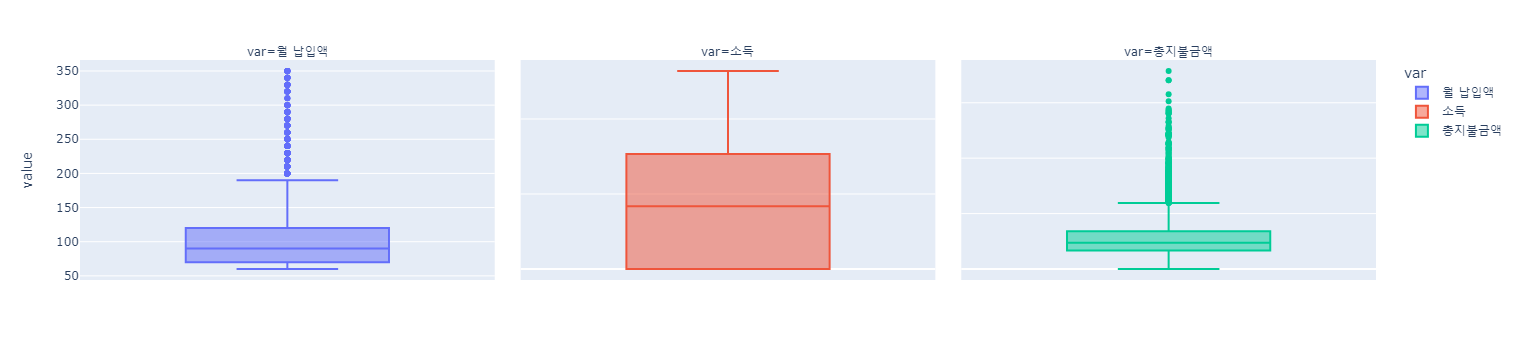

In [43]:
fig = data_choice.melt(value_vars = ["월 납입액", "소득", "총지불금액"],
                 var_name = "var").plot(y = "value", color="var", kind = "box",
                                       backend = "plotly",facet_col= "var")

fig.update_yaxes(matches = None)
fig.update_xaxes(matches = None)

### (2) 수치형 변수 이상치 처리 

In [44]:
import scipy.stats as spst

z_list = ['소득','월 납입액','총지불금액']

z_df = data_choice[z_list].apply(spst.zscore, axis = 0)
z_df.columns = [i + "_z" for i in z_list]

data_choice = pd.concat([data_choice, z_df],axis=1)

### (3) 이상치 검토

**z-score가 3이상이거나 -3 이하**이면 이상치로 검토

*  `+` 이상치의 최소값들을 찾기 

#### 월 납입액 이상치 검토

In [45]:
out = lambda x : True if abs(x)>=3 else False

a = data_choice["월 납입액_z"].map(out)
a1 = data_choice["월 납입액"][a]
a2 = min(a1)
a2

230

`-` 위 단계를 한번에

In [46]:
min([j for i,j in zip(data_choice["월 납입액_z"],data_choice["월 납입액"]) if abs(i)>=3])

230

#### 소득 변수 이상치 검토

In [47]:
a = data_choice["소득_z"].map(out)

a1 = data_choice["소득"][a]
a1

Series([], Name: 소득, dtype: int64)

#### 총 지불액 이상치 검토

In [48]:
a = data_choice["총지불금액_z"].map(out)

a1 = data_choice["총지불금액"][a]

a2 = np.min(a1)

a2

1612000

#### 전체 확인

In [49]:
print("소득 이상치 최소값(기준) : ",min([j if abs(i)>=3 else np.nan for i,j in zip(data_choice["소득_z"],data_choice["소득"])]) )
print("월 납입액 이상치 최소값(기준) : ",min([j for i,j in zip(data_choice["월 납입액_z"],data_choice["월 납입액"]) if abs(i)>=3])  )
print("총 지불 금액 이상치 최소값(기준) : ", min([j for i,j in zip(data_choice["총지불금액_z"],data_choice["총지불금액"]) if abs(i)>=3 ]))

소득 이상치 최소값(기준) :  nan
월 납입액 이상치 최소값(기준) :  230
총 지불 금액 이상치 최소값(기준) :  1612000


### (4) 이상치 대체

#### 월 납입액 이상치 대체

In [50]:
m1 = min([j for i,j in zip(data_choice["월 납입액_z"],data_choice["월 납입액"]) if abs(i)>=3])

data_choice["월 납입액_z"] = [m1 if abs(i)>=3 else j for i,j in zip(data_choice["월 납입액_z"],data_choice["월 납입액"])] 

#### 총 지불액 이상치 대체

In [51]:
m2 = min([j for i,j in zip(data_choice["총지불금액_z"],data_choice["총지불금액"]) if abs(i)>=3])

data_choice["총지불금액"] = [m2 if abs(i)>=3 else j for i,j in zip(data_choice["총지불금액_z"],data_choice["총지불금액"])] 

#### 소득변수 이상치 대체

`1` 소득 변수는 이상치가 없는 것으로 확인 되었으나, 소득이 아예없는 고객이 많았음

`2` 따라서 해당 변수는 이산화 인코딩을 통헤 활용하는게 좋겠당

In [52]:
data_choice["소득"] = [0 if i == 0 else 1 for i in data_choice["소득"]]

data_choice["소득"].value_counts()

소득
1    8972
0    3028
Name: count, dtype: int64

#### z-score 컬럼 삭제 & type 변경

In [53]:
data_choice_n = data_choice.drop(['소득_z','월 납입액_z','총지불금액_z'],axis = 1)
data_choice_n.head()

,AGE,고용상태,Willingness to pay/Stay,상품타입,교육수준,소득,월 납입액,타 상품 보유 현황,총지불금액,거주지사이즈,자동차
CID,,,,,,,,,,,
1,3,0,2.616381,0,0,0,80,1.0,631000,0,0
2,1,1,6.352530,0,0,1,80,4.0,54000,0,0
3,2,0,4.974354,0,0,1,60,4.0,362000,0,0
4,5,1,13.480284,1,0,1,110,2.0,1264000,1,0
5,4,1,9.776436,0,1,1,120,3.0,947000,0,0


In [58]:
data_choice_n.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AGE                      12000 non-null  int64  
 1   고용상태                     12000 non-null  int64  
 2   Willingness to pay/Stay  12000 non-null  float64
 3   상품타입                     12000 non-null  int64  
 4   교육수준                     12000 non-null  int64  
 5   소득                       12000 non-null  int64  
 6   월 납입액                    12000 non-null  int64  
 7   타 상품 보유 현황               12000 non-null  float64
 8   총지불금액                    12000 non-null  int64  
 9   거주지사이즈                   12000 non-null  int64  
 10  자동차                      12000 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 1.1 MB


In [61]:
data_choice_n = data_choice_n.astype("float64")

In [62]:
data_choice_n.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AGE                      12000 non-null  float64
 1   고용상태                     12000 non-null  float64
 2   Willingness to pay/Stay  12000 non-null  float64
 3   상품타입                     12000 non-null  float64
 4   교육수준                     12000 non-null  float64
 5   소득                       12000 non-null  float64
 6   월 납입액                    12000 non-null  float64
 7   타 상품 보유 현황               12000 non-null  float64
 8   총지불금액                    12000 non-null  float64
 9   거주지사이즈                   12000 non-null  float64
 10  자동차                      12000 non-null  float64
dtypes: float64(11)
memory usage: 1.1 MB


# 5. 스케일링 

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(data_choice_n)

scaler_data = pd.DataFrame(scaler.transform(data_choice_n))
scaler_data.columns = data_choice_n.columns

# 6. K-means 모델

 > **비지도학습의 대표적인 군집분석을 위한 모델로 주어진 데이터를 K개의 클러스터로 묶는 알고리즘**
 > * K 군집의 초기 중심에서 시작해서 중심을 바꾸는 단계를 사용하여 데이터를 가장 가까운 군집으로 포함시켜 분류하는 모델
 > * 장점: 단순 알고리즘 및 빠른 연산 속도
 > * 단점: 이상치, 노이즈에 민감하고 초기 군집 수 결정 단계가 필요함

## (1) import

In [65]:
from yellowbrick.cluster import KElbowVisualizer 
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN

## (2) 모델 적합

In [68]:
k = list(range(3,10,2))


# 모델 만들기 (그룹수 : n_clusters 파라미터 사용)
# 동일값을 위해 random_state=2023, n_init=10으로 설정값을 같이 해본다.
# [참고]n_init의 기본 값이 10 이나 warning을 없애기 위해 지정해준다.
k_model = KMeans(n_init = 10, n_clusters = 3, random_state = 200)

k_model.fit(scaler_data)

pred = k_model.predict(scaler_data)

In [69]:
k_model.cluster_centers_

array([[ 4.14530612e-01,  8.57142857e-01,  7.62306195e-02,
         7.83673469e-02,  1.00000000e+00,  1.00000000e+00,
         1.33455313e-01,  4.25306122e-01,  2.50667950e-01,
         1.10204082e-01,  8.81632653e-02],
       [ 4.31137910e-01,  1.00000000e+00,  7.85980651e-02,
         9.46196660e-02, -4.85722573e-16,  1.00000000e+00,
         1.37867059e-01,  4.32436611e-01,  2.78258895e-01,
         9.35374150e-02,  8.99814471e-02],
       [ 3.93127467e-01, -6.32827124e-15,  7.01693293e-02,
         8.52101231e-02,  4.48107732e-02,  2.96958440e-01,
         1.39932588e-01,  4.34796068e-01,  4.25671810e-01,
         1.17250987e-01,  9.65869515e-02]])

## (3) 성능지표 확인 1. inertia

In [73]:
# 3가지 성능지표를 통해서 확인해보기

# 1. inertia(이너셔) : 각 데이터와 센트로이드(중심) 사이의 평균 제곱거리로 도출한 모델 (model.inertia_로 쓴다)
# 2. score 매서드: 이너셔의 음수값을 반환( model.score(df))
# 3. %time : 모델학습에 소요되는 시간 측정

ks = list(range(3,11,1))
inertia_list = []
for k in ks: 
    %time
    exec(f"k_model_{k} = KMeans(n_init = 10, n_clusters = {k}, random_state = 2023)")     
    exec(f"k_model_{k}.fit(scaler_data)")
    exec(f"inertia_list.append(k_model_{k}.inertia_)")
    exec(f"_iner = k_model_{k}.inertia_")
    print(f"n_cluster : {k}, inertia : {_iner}") 
    print('---------') # n_cluster, inertia 결과 출력

CPU times: total: 0 ns
Wall time: 0 ns
n_cluster : 3, inertia : 7630.738131128096
---------
CPU times: total: 0 ns
Wall time: 0 ns
n_cluster : 4, inertia : 6630.463665302053
---------
CPU times: total: 0 ns
Wall time: 0 ns
n_cluster : 5, inertia : 5871.217116262518
---------
CPU times: total: 0 ns
Wall time: 0 ns
n_cluster : 6, inertia : 5275.1942451921
---------
CPU times: total: 0 ns
Wall time: 0 ns
n_cluster : 7, inertia : 4808.309158286751
---------
CPU times: total: 0 ns
Wall time: 0 ns
n_cluster : 8, inertia : 4384.582013588153
---------
CPU times: total: 0 ns
Wall time: 0 ns
n_cluster : 9, inertia : 3987.128229343856
---------
CPU times: total: 0 ns
Wall time: 0 ns
n_cluster : 10, inertia : 3693.3064711892653
---------


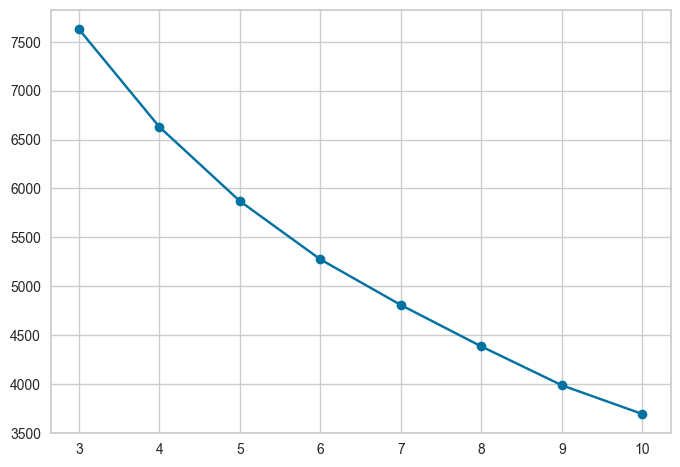

In [74]:
#plt로 결과출력

plt.plot(ks, inertia_list,"-ob")
plt.show()

## (4) 성능지표 확인 2. Elbow Method

* yellowbrick의 k-Elbow Mehod를 활용해서 최적의 k 값을 구하기(k값 결정하기 쉽게 도와주는 함수)

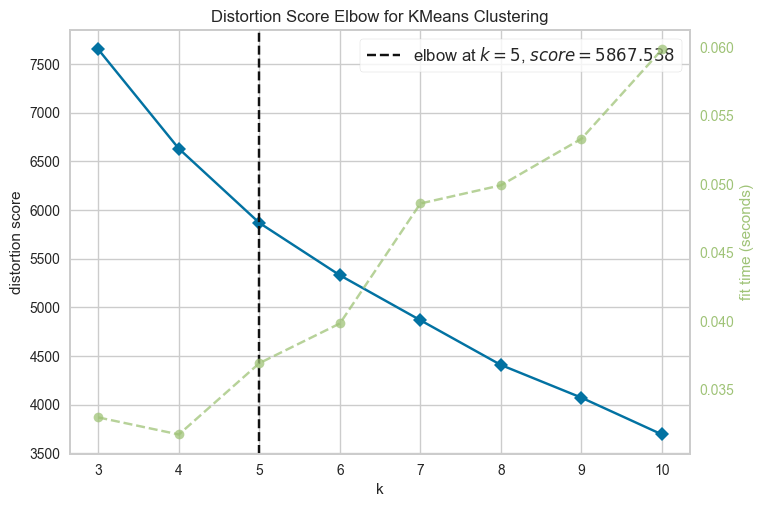

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [75]:
# 1. 모델 선언하기(random_state=2023, n_init = 10 으로 설정)(model_E로 할당)
model = KMeans( n_init=10, random_state = 200)

# 2. KElbowVisualizer 에 k-means 모델과 k값 넣어서 만들기(Elbow_M 에 할당)
# k값은 k=(3,11)사이의 값중에서 찾는 것으로 넣으면 된다.
model_E = KElbowVisualizer(model, k=(3,11))


# 3. Elbow 모델 학습하기(fit)
model_E.fit(scaler_data)


# 4. Elbow 모델 확인하기(show()활용)
model_E.show()

`-` 최적의 k값은 5로 선정

* distortion score : 각 데이터들의 군집 중심과의 평균 거리

## (5) 최적의 k 값으로 모델링

In [77]:
# 1. scale이 안된 원본 data 로드

data_o = pd.read_csv("customers_seg.csv", encoding = "CP949")

# 2. 'CID'는 활용하지 않을 예정으로 index
data_o.set_index("CID",inplace=True)

# 3. 데이터 상위 5개 확인하기
data_o.head()

,AGE,등록(계/피),고용상태,성별,Willingness to pay/Stay,갱신,상품타입,교육수준,소득,지역,결혼여부,월 납입액,VOC,타 상품 보유 현황,온라인방문빈도,갱신인센티브,판매채널,총지불금액,자동차,거주지사이즈
CID,,,,,,,,,,,,,,,,,,,,
1,3,피보험자,무직,1,2.616381,0,기본,대학졸업,0,도시근교,미혼,80,0,1,자주방문,없음,자사영업,631000,일반세단,소
2,1,계약자,고용,0,6.352530,0,기본,고졸이하,102887400,시골,미혼,80,1,4이상,비방문,포인트,인터넷,54000,일반세단,중
3,2,계약자,휴직,0,4.974354,0,기본,대학졸업,22159500,도시근교,기혼,60,0,4이상,비방문,할인,자사영업,362000,일반세단,중
4,5,계약자,고용,1,13.480284,0,고급,고졸이하,51562500,도시근교,기혼,110,0,2,비방문,할인,자사영업,1264000,컴팩트카,대
5,4,계약자,고용,0,9.776436,0,기본,석사,26820200,도시근교,기혼,120,0,3,비방문,없음,대리점,947000,SUV,중


In [80]:
k4 = 5

k_model = KMeans(random_state = 200, n_init=10, n_clusters = k4 )

k_model.fit(scaler_data)

kmeans_p = k_model.predict(scaler_data)

scaler_data["clust"] = kmeans_p
data_d1 = pd.concat([data_o.reset_index(drop = True), scaler_data[["clust"]]], axis = 1)

`-` 원본 데이터와 합치기

In [85]:
index_label = list(range(1,data_d1.shape[0]+1))
index_label[-1]
data_d1.index = index_label
data_d1 = data_d1.rename_axis(index = "CID")
output = data_d1.copy()
output.head()

,AGE,등록(계/피),고용상태,성별,Willingness to pay/Stay,갱신,상품타입,교육수준,소득,지역,...,월 납입액,VOC,타 상품 보유 현황,온라인방문빈도,갱신인센티브,판매채널,총지불금액,자동차,거주지사이즈,clust
CID,,,,,,,,,,,,,,,,,,,,,
1,3,피보험자,무직,1,2.616381,0,기본,대학졸업,0,도시근교,...,80,0,1,자주방문,없음,자사영업,631000,일반세단,소,2
2,1,계약자,고용,0,6.352530,0,기본,고졸이하,102887400,시골,...,80,1,4이상,비방문,포인트,인터넷,54000,일반세단,중,1
3,2,계약자,휴직,0,4.974354,0,기본,대학졸업,22159500,도시근교,...,60,0,4이상,비방문,할인,자사영업,362000,일반세단,중,4
4,5,계약자,고용,1,13.480284,0,고급,고졸이하,51562500,도시근교,...,110,0,2,비방문,할인,자사영업,1264000,컴팩트카,대,0
5,4,계약자,고용,0,9.776436,0,기본,석사,26820200,도시근교,...,120,0,3,비방문,없음,대리점,947000,SUV,중,3


## (6) 프로파일링

`-` 군집의 구조와 내용을 분석하고 도메인 및 현업업무의 '추론'을 바탕으로 분석의 결과를 적용 가능하도록 하는 과정. 데이터를 통해서 군집별 특성을 파악하는 것에 목적은 두는 기법

### a. 군집별 수치형 변수 분포 확인

In [88]:
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

C:\Users\rkdcj\AppData\Local\Temp\ipykernel_4972\3364328251.py:11: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



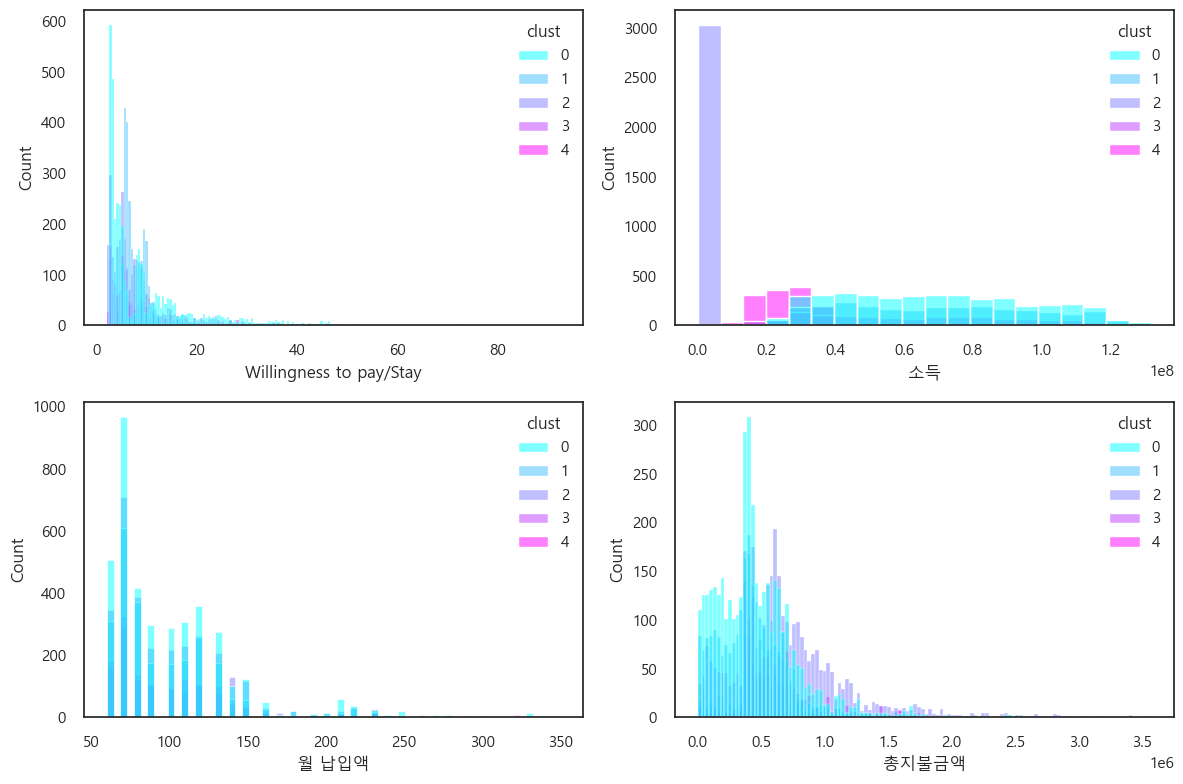

In [89]:
fig, axes = plt.subplots(2,2, figsize = (12,8))


f_lst = [["Willingness to pay/Stay", "소득"],["월 납입액","총지불금액","clust"]]

for i in range(2) : 
    for j in range(2) : 
        sns.histplot(x = f_lst[i][j], data = output, hue="clust", ax = axes[i][j], palette='cool') 
        
fig.tight_layout()
fig.show()

In [90]:
f_lst = ["Willingness to pay/Stay", "소득","월 납입액","총지불금액","clust"]

In [91]:
agg1 = output[f_lst].groupby("clust").\
    agg({"Willingness to pay/Stay": np.mean,
          "소득": np.mean,
          "월 납입액": np.mean,
          "총지불금액": np.mean,
          })

### b. 군집간 수치형 변수들의 차이 검정

In [96]:
for i in range(5) : 
    exec(f"w_{i} = output[f_lst].loc[map(lambda x : x == i,output.clust), 'Willingness to pay/Stay']")
stat = spst.f_oneway(w_0,w_1,w_2,w_3,w_4)[0]
pvalue = spst.f_oneway(w_0,w_1,w_2,w_3,w_4)[1]
result = pd.DataFrame(columns = ["stat","pvalue","var"])
result.loc[0] = [stat, pvalue,"Willingness to pay/Stay"] 

In [97]:
result

,stat,pvalue,var
0,31.37888,4.856769e-26,Willingness to pay/Stay


In [98]:
for i in range(5) : 
    exec(f"w_{i} = output[f_lst].loc[map(lambda x : x == i,output.clust), '소득']")

    stat = spst.f_oneway(w_0,w_1,w_2,w_3,w_4)[0]
pvalue = spst.f_oneway(w_0,w_1,w_2,w_3,w_4)[1]
result.loc[1] = [stat, pvalue,"소득"] 

In [99]:
for i in range(5) : 
    exec(f"w_{i} = output[f_lst].loc[map(lambda x : x == i,output.clust), '월 납입액']")

stat = spst.f_oneway(w_0,w_1,w_2,w_3,w_4)[0]
pvalue = spst.f_oneway(w_0,w_1,w_2,w_3,w_4)[1]
result.loc[2] = [stat, pvalue,"월 납입액"] 

In [100]:
for i in range(5) : 
    exec(f"w_{i} = output[f_lst].loc[map(lambda x : x == i,output.clust), '총지불금액']")

stat = spst.f_oneway(w_0,w_1,w_2,w_3,w_4)[0]
pvalue = spst.f_oneway(w_0,w_1,w_2,w_3,w_4)[1]
result.loc[3] = [stat, pvalue,"총지불금액"] 

In [101]:
result

,stat,pvalue,var
0,31.378880,4.856769e-26,Willingness to pay/Stay
1,5476.648834,0.000000e+00,소득
2,3.560818,6.578685e-03,월 납입액
3,444.750442,0.000000e+00,총지불금액


In [102]:
agg1

,Willingness to pay/Stay,소득,월 납입액,총지불금액
clust,,,,
0,9.916307,6.917161e+07,101.339761,457605.683837
1,7.967621,6.964916e+07,97.863079,441794.618124
2,8.367462,0.000000e+00,101.172391,739828.599736
3,8.940833,6.234310e+07,98.702041,404278.367347
4,8.452066,2.504257e+07,99.179046,603396.403440


### c. 타겟 군집 선정

`-` 0번 군집 : 기대확률이 상위, 소득이 높고, 월 납입액 중간, 총 지불금액이 하위권인 그룹

`-` 1번 군집 : 기대확률 상위권, 소득이 중간, 월납입액 상위, 총 지불금액이 상위권인 그룹 **(가장 마케팅 전략을 세우기 좋은 그룹)**

`-` 2번 군집 : 기대확률 중간, 소득이 없음, 월납입액 상위, 총 지불금액이 상위권인 그룹

`-` 3번 군집 : 기대확률 중간, 소득이 중간, 월납입액 적음, 총 지불금액이 하위권인 그룹

`-` 4번 군집 : 기대확률 중간, 소득과 월납입액이 높고, 총 지불금액이 하위권인 그룹

`-` 5번 군집 : 기대확률, 월 납입액이 적고, 총 지불금액이 중간 정도 되는 그룹